In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy.signal import medfilt, find_peaks, find_peaks_cwt, lfilter, savgol_filter
import numpy as np
import tifffile as ti
from skimage.filters.thresholding import threshold_li, threshold_yen
import cv2
from skimage.util import img_as_uint
from scipy import ndimage
matplotlib.rcParams['figure.figsize'] = [18, 18]

In [2]:
from scipy import ndimage, fftpack, stats
from matplotlib import pyplot as plt
from math import floor, ceil

from skimage import restoration
from skimage.util import img_as_uint
from skimage.filters import unsharp_mask

import skimage

def crop_to_rectangle(image):
	"""
	Crop the image into a square. This is sometimes useful, especially
	in methods employing FFT.
	"""
	dims = image.shape

	if dims[0] > dims[1]:
		diff = 0.5*(dims[0]-dims[1])
		image = image[int(floor(diff)): -int(ceil(diff)), :]
	elif dims[1] > dims[0]:
		diff = 0.5*(dims[1]-dims[0])
		image = image[:, int(floor(diff)): -int(ceil(diff))]
	return image

def calculate_power_spectrum(image, normalize_power=True):
	"""
	A function that is used to calculate a centered 2D power spectrum.
	Additionally the power spectrum can be normalized by image dimensions
	and image intensity mean, if necessary.
	"""
	power = np.abs(fftpack.fftshift(fftpack.fft2(image))) ** 2
	if normalize_power:
		dims = image.shape[0] * image.shape[1]
		mean = np.mean(image)
		power = power / (dims * mean)
	return power

def calculate_summed_power(power, spacing):
	"""
	Calculate a 1D power spectrum fro 2D power spectrum, by summing all rows and
	columns, and then summing negative and positive frequencies, to form a
	N/2+1 long 1D array. This approach is significantly faster to calculate
	than the radial average.
	"""

	sum = np.zeros(power.shape[0])
	for i in range(len(power.shape)):
		sum += np.sum(power, axis=i)
	zero = floor(float(sum.size) / 2)

	sum[zero + 1:] = sum[zero + 1:] + sum[:zero - 1][::-1]
	sum = sum[zero:]
	dx = spacing[0]
	f_k = np.linspace(0, 1, sum.size) * (1.0 / (2 * dx))

	simple_power = [f_k, sum]
	return simple_power

def analyze_power_spectrum(image, power_averaging="additive", power_threshold=0.4):

	# Cropping the image to a rectangle.
	image = crop_to_rectangle(image)

	power = calculate_power_spectrum(image)

	# Choose a method to calculate 1D power spectrum
	if power_averaging == "radial":
		# simple_power = calculate_radial_average()
		simple_power = calculate_summed_power(power, [1, 1])
	elif power_averaging == "additive":
		simple_power = calculate_summed_power(power, [1, 1])
	else:
		raise NotImplementedError

	# Extract the power spectrum tail
	hf_sum = simple_power[1][simple_power[0] >
							 power_threshold * simple_power[0].max()]

	# Calculate parameters and metrics.

	std = np.std(hf_sum)

	return np.array([std])

def focus_with_normalized_variance(image):
	mean = np.mean(image)
	var = np.var(image)

	return np.array([var/mean])
def focus_with_entropy(image):
	entropy = skimage.measure.shannon_entropy(image)
	return entropy


def find_best_global_focus_plane(image):

	img = ti.imread(image)
	measure = []
	clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8))
	for stack in img:
		stack_norm = np.divide(stack, np.max(stack))
		stack = img_as_uint(stack_norm)
		stack = clahe.apply(stack)
		focus_measure = analyze_power_spectrum(stack, power_threshold=0.05)
		# focus_measure = focus_with_normalized_variance(stack)
		measure.append(focus_measure)

	# plt.plot(measure)
	# plt.show()
	best_stack_idx = np.argmax(measure)
	# print(best_stack_idx)
	best_stack = img[best_stack_idx, :, :]
	return best_stack_idx

In [3]:
def list_images_of_point(images, point):
    """
    Given a list of images and a point, returns a list of image names that contain the point in their file names.
    
    Parameters:
        images (list): List of image file names.
        point (str): Point to search for in image file names.
    
    Returns:
        list: List of image names that contain the point in their file names.
    """
    
    # Initialize empty list to store image names
    image_names = []
    
    # Iterate through list of images
    for image in images:
        # Check if point is in the image file name
        if point in os.path.basename(image):
            # If point is found, append image name to list
            image_names.append(image)
    
    # Return list of image names
    return image_names

def get_square_bbox(mask, expand=10):
	# Creation of the bounding box.
	y, x = np.where(mask != 0)

	ymin = int(np.min(y))
	ymax = int(np.max(y))
	xmin = int(np.min(x))
	xmax = int(np.max(x))

	w = ymax-ymin
	h = xmax-xmin

	ymin -= expand//2
	xmin -= expand//2

	if ymin < 0:
		ymin = 0
	if xmin < 0:
		xmin = 0

	w += expand
	h += expand

	square_dim = max(w, h)

	# For some reason, the next steps only work with a image whose dimensions can be divided by four.
	while (square_dim % 4 != 0):
		square_dim += 1

	# If the bounding box would come out of the image, moove the bounding box's origin (xmin, ymin).
	if (xmin + square_dim) > mask.shape[1]:
		xmin = (xmin - ((xmin + square_dim) - mask.shape[1]))

	if (ymin + square_dim) > mask.shape[0]:
		ymin = (ymin - ((ymin + square_dim) - mask.shape[0]))

	return [ymin, xmin, square_dim]

def get_bbox(mask, expand=10):
	# Creation of the bounding box.
	y, x = np.where(mask != 0)

	ymin = int(np.min(y))
	ymax = int(np.max(y))
	xmin = int(np.min(x))
	xmax = int(np.max(x))

	w = ymax-ymin
	h = xmax-xmin

	ymin -= expand//2
	xmin -= expand//2

	if ymin < 0:
		ymin = 0
	if xmin < 0:
		xmin = 0

	w += expand
	h += expand


	return [ymin, xmin, w, h]

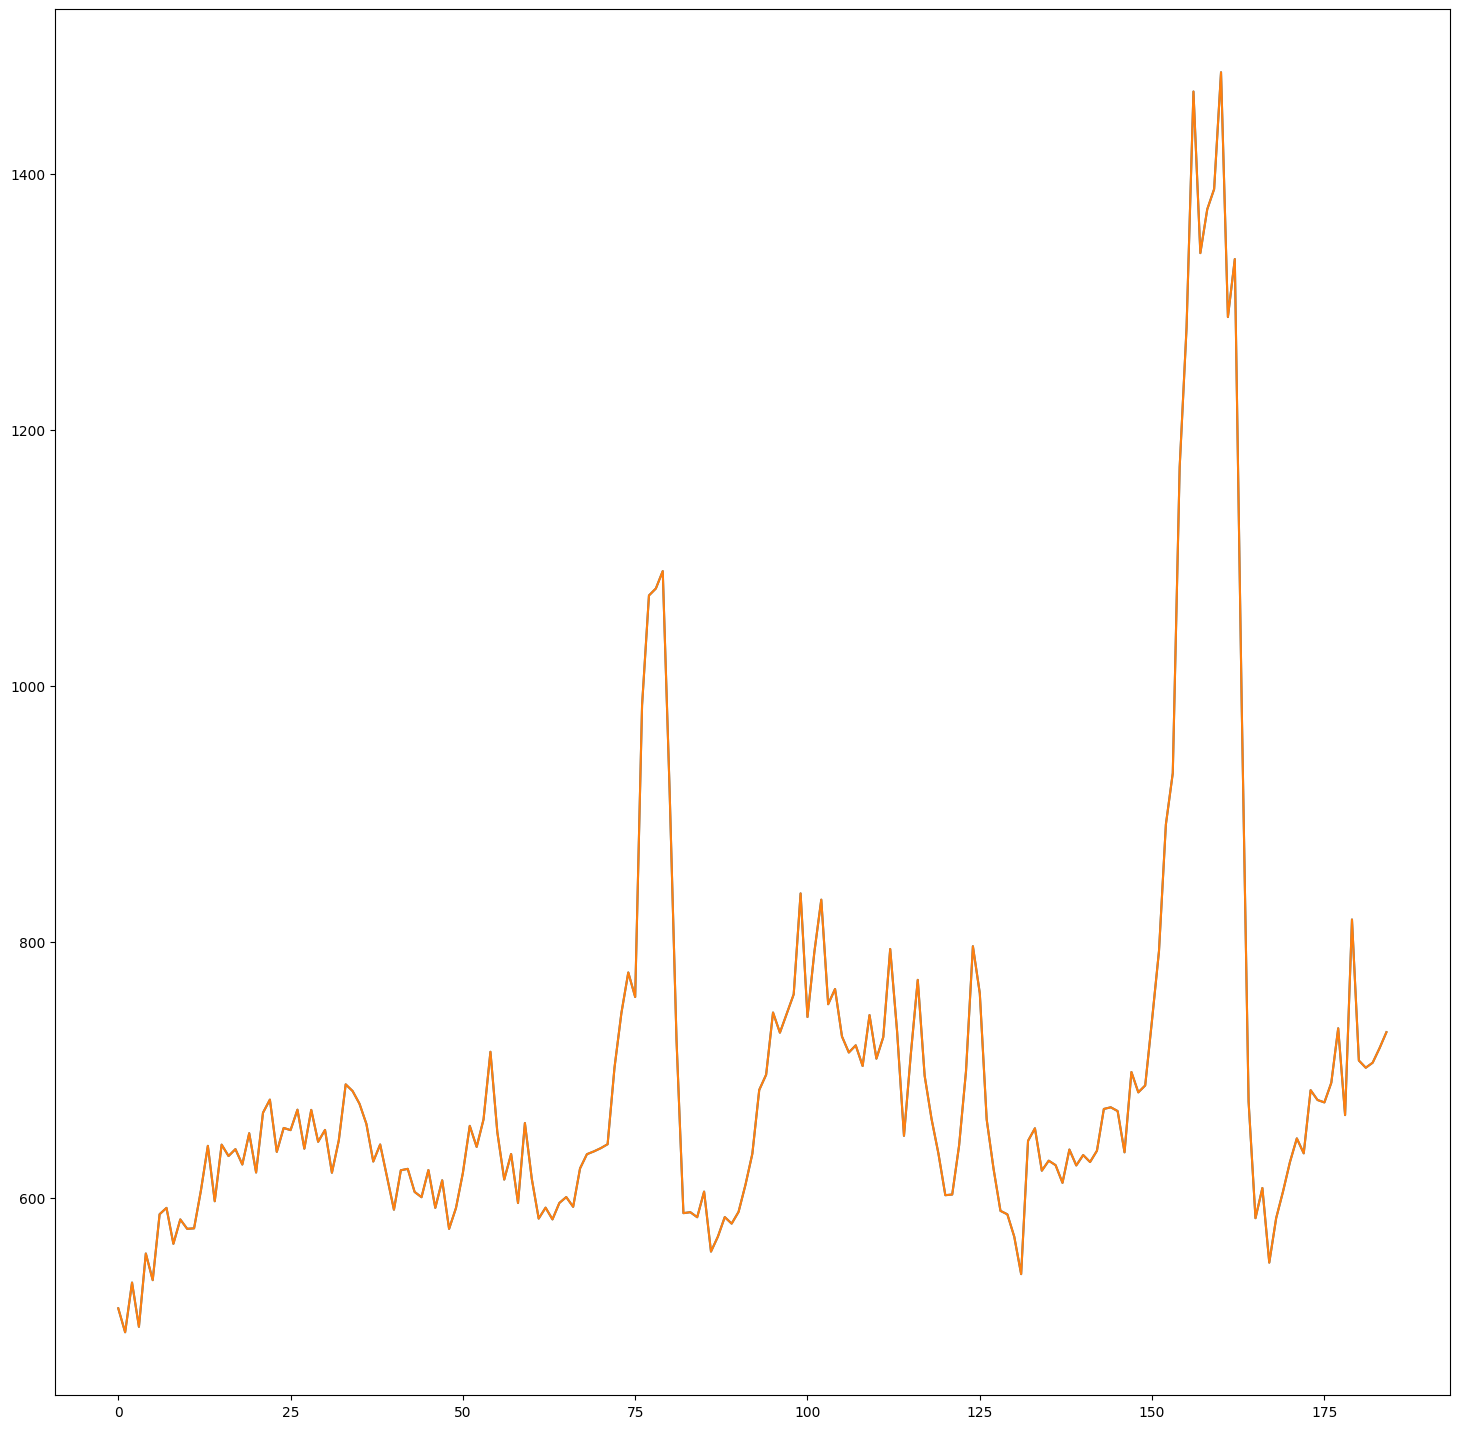

[102 104 107 109 113 115 117 119 122 126 128 130 133 138 142 145 147 151
 154 157 159 162 165 174 179 185 188 195 199 202 204 207 209 212 216 224
 233 235 238 240 244 247 256 260 262 266 271 273 277 279]
[101 103 105 108 110 114 116 118 120 123 127 129 131 137 140 144 146 148
 152 156 158 161 163 166 175 184 186 189 196 200 203 206 208 210 214 220
 231 234 237 239 241 246 248 257 261 265 267 272 275 278 281]


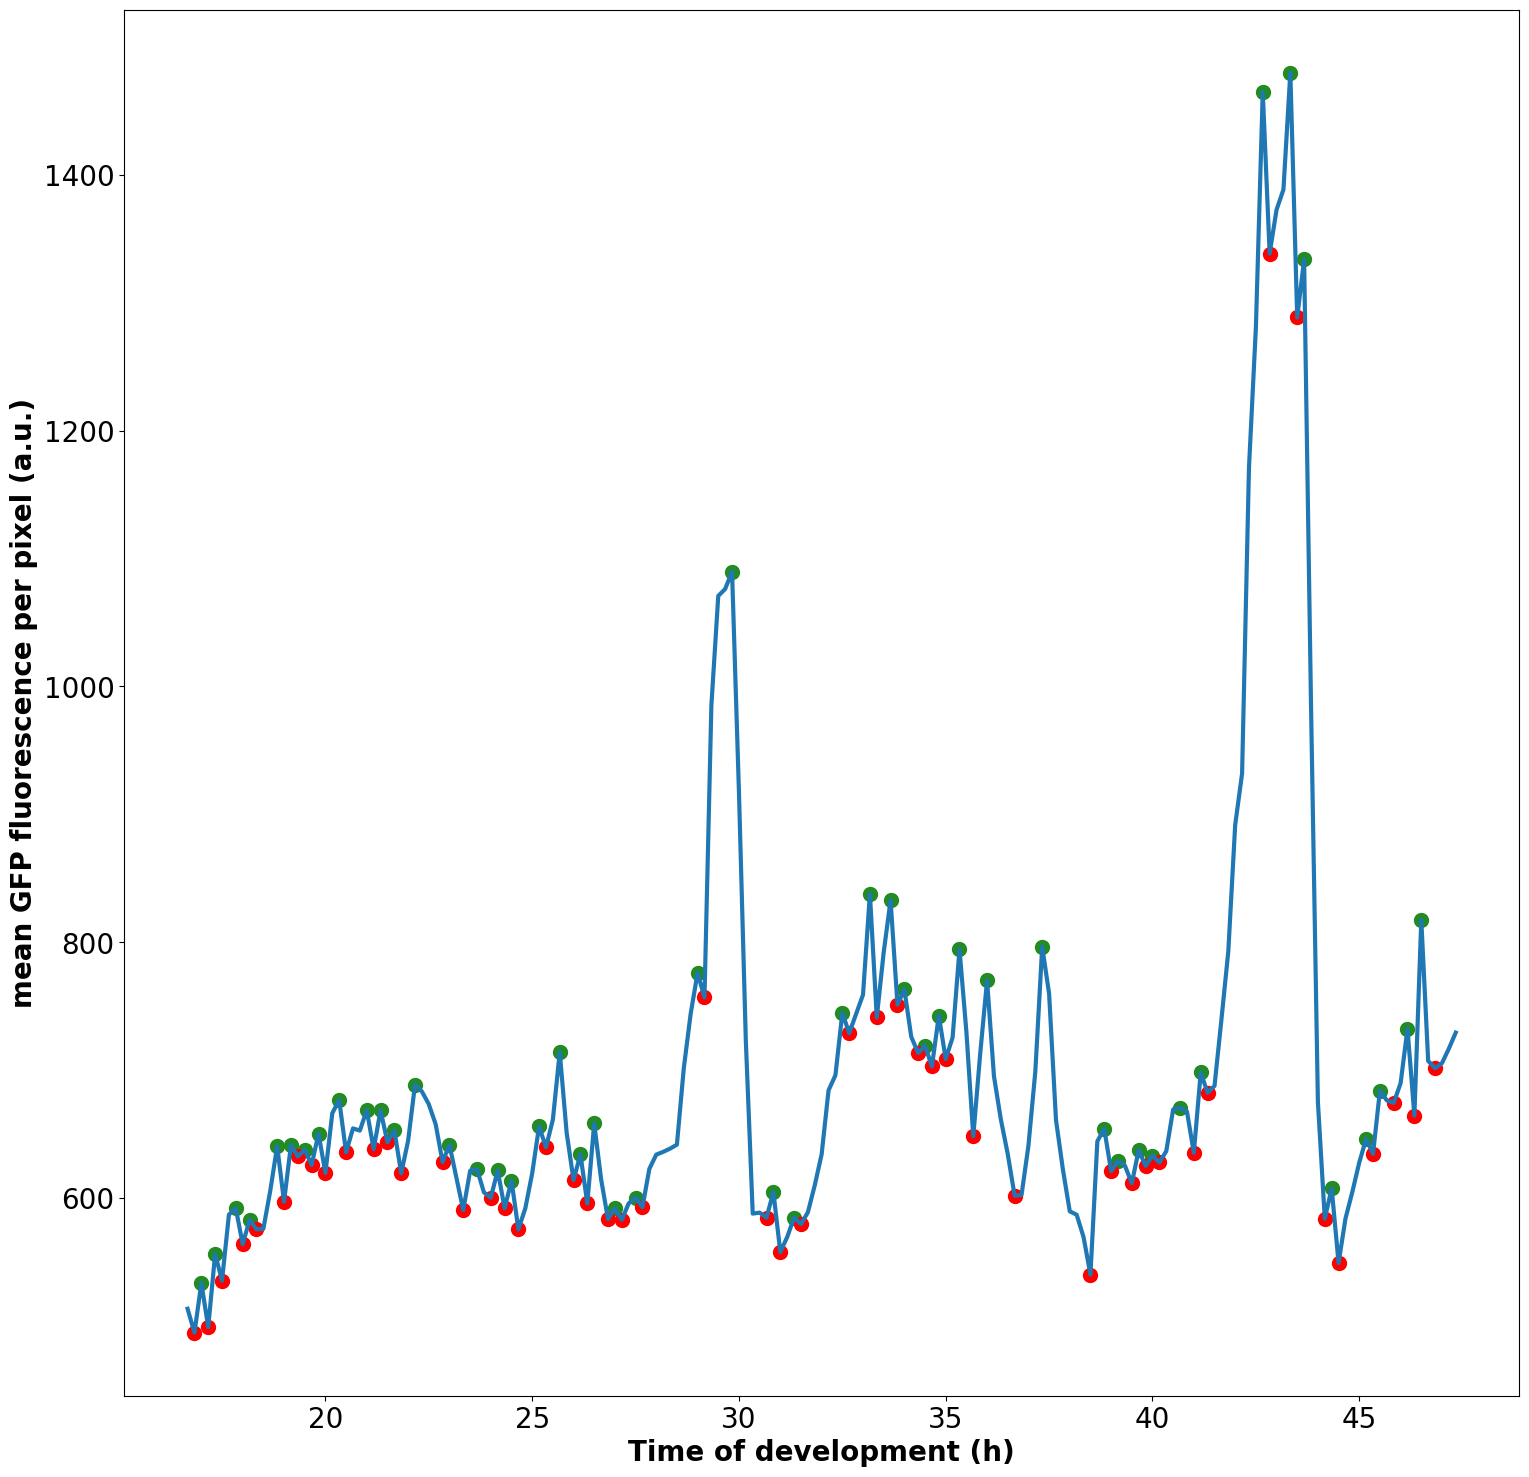

In [4]:
csv_path = "./nuclei_GFP_intensity.csv"

dataframe = pd.read_csv(csv_path)

point = "Point0013"
dataframe = dataframe[dataframe['Point'] == point]

dataframe.drop('Point', inplace=True, axis=1)

mean_GFP_intensity = dataframe.to_numpy().squeeze()
index_range = np.array(list(range(np.shape(mean_GFP_intensity)[0])))

mean_GFP_intensity = mean_GFP_intensity[100:]
index_range = index_range[100:]


# median_mean_GFP_intensity = medfilt(mean_GFP_intensity, 1)
# median_mean_GFP_intensity = savgol_filter(mean_GFP_intensity, 4, 3)
median_mean_GFP_intensity = mean_GFP_intensity

plt.plot(mean_GFP_intensity)
plt.plot(median_mean_GFP_intensity)
plt.show()

peaks, _ = find_peaks(median_mean_GFP_intensity, prominence=5)
neg_median_GFP_intensity = -median_mean_GFP_intensity
neg_peaks, _ = find_peaks(neg_median_GFP_intensity, prominence=5)

# peaks, _ = find_peaks(median_mean_GFP_intensity, prominence=5, distance = 5, width=2)
# neg_median_GFP_intensity = -median_mean_GFP_intensity
# neg_peaks, _ = find_peaks(neg_median_GFP_intensity, prominence=5, distance=5, width=2)

right_peaks = index_range[peaks]
right_neg_peaks = index_range[neg_peaks]

timeMin = index_range*10
timeHours = timeMin/60

matplotlib.rcParams.update({'font.size': 20})

plt.scatter(timeHours[peaks], median_mean_GFP_intensity[peaks], 100,color = 'forestgreen')
plt.scatter(timeHours[neg_peaks], median_mean_GFP_intensity[neg_peaks], 100, color = "r")
plt.plot(timeHours, median_mean_GFP_intensity, linewidth=3)

plt.ylabel("mean GFP fluorescence per pixel (a.u.)", fontweight="bold")
plt.xlabel('Time of development (h)', fontweight="bold")

# plt.savefig(f'./plots_for_presentation/plot_{point}.png', dpi = 300)
# plt.show()
right_all_peaks = np.sort(np.append(right_peaks, right_neg_peaks))
print(right_peaks)
print(right_neg_peaks)

In [5]:
# gfp_dir = "/mnt/external.data/TowbinLab/ngerber/20200317_wBT280_wBT281_LIPSI_daf16_GFP_20C/analysis/ch1_WBT281_focused/"
# images_gfp = sorted([os.path.join(gfp_dir, x) for x in os.listdir(gfp_dir)])
# images_gfp = list_images_of_point(images_gfp, point)

# clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(8,8))

# for peak in right_neg_peaks:
#     # best_stack_idx = find_best_global_focus_plane(images_gfp[peak])
#     print(peak)
#     # best_stack_idx = 8
#     gfp = ti.imread(images_gfp[peak])
#     gfp_norm = np.divide(gfp, np.max(gfp))
#     gfp_contrast = img_as_uint(gfp_norm)
#     # gfp_contrast = clahe.apply(gfp_contrast)

#     # thresh_yen = threshold_yen(gfp_contrast)
#     # gfp_mask_yen = (gfp_contrast > 1.2*thresh_yen)
#     # gfp_mask_yen = cv2.GaussianBlur(gfp_mask_yen.astype("uint8"), (25, 25), 0)

    
#     # ymin, xmin, w, h = get_bbox(gfp_mask_yen)

#     # gfp_contrast = gfp_contrast[ymin:ymin+w, xmin:xmin+h]
#     # print(peak)

#     # plt.imshow(gfp_mask_yen[ymin:ymin+w, xmin:xmin+h])
#     # plt.show()

#     plt.imshow(gfp_contrast)
#     plt.show()

#     # if peak in right_peaks:
#     #     ti.imwrite(f"./worms_for_presentation/{point}/{peak}_peak.tiff", gfp_contrast)
#     # if peak in right_neg_peaks:
#     #     ti.imwrite(f"./worms_for_presentation/{point}/{peak}_well.tiff", gfp_contrast)

13
[ 92.51683066 179.20766442 261.39306059          nan]
[102 104 107 109 113 115 117 119 122 126 128 130 133 138 142 145 147 151
 154 157 159 162 165 174 179 185 188 195 199 202 204 207 209 212 216 224
 233 235 238 240 244 247 256 260 262 266 271 273 277 279]


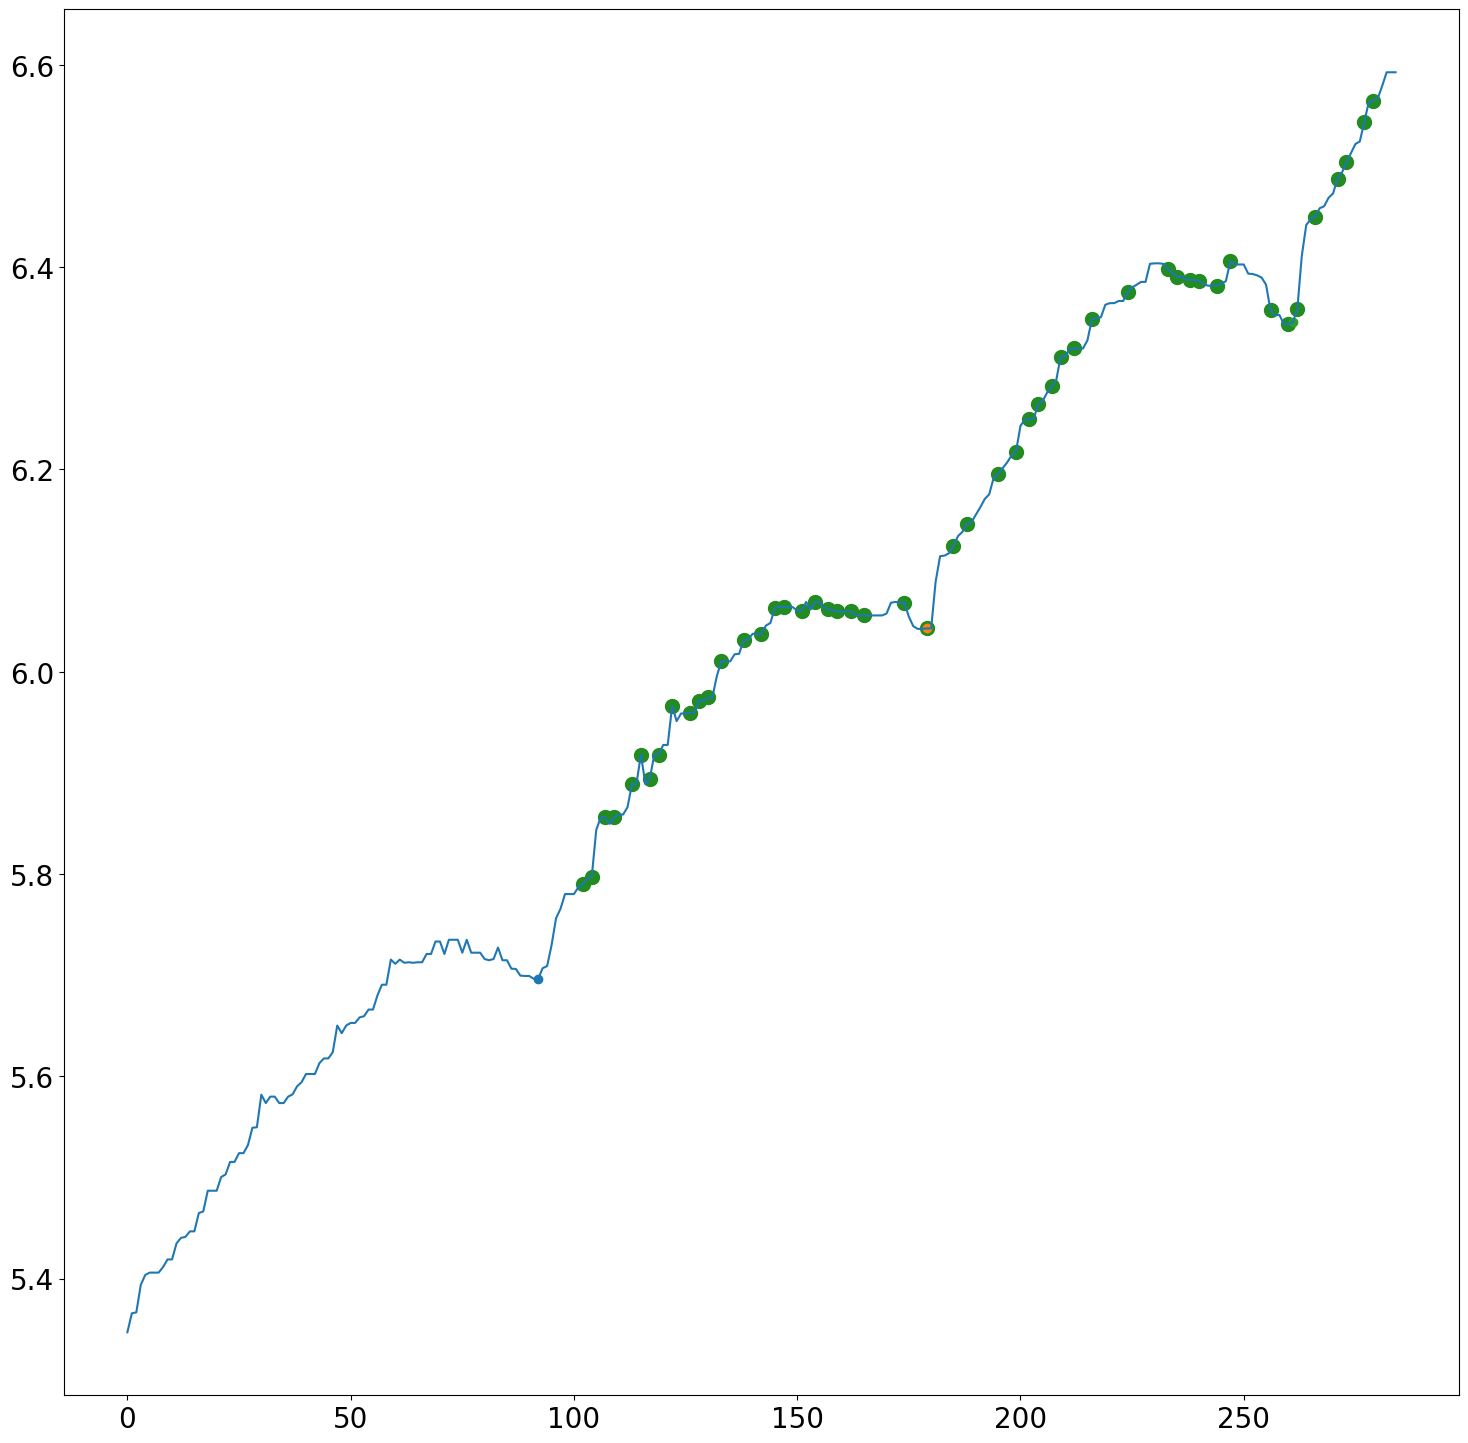

[110.93906810035845, 113.24611708482679, 116.7066905615293, 119.01373954599764, 123.62783751493433, 125.93488649940267, 128.241935483871, 130.54898446833934, 134.00955794504185, 138.62365591397852, 140.93070489844686, 143.2377538829152, 146.6983273596177, 152.46594982078855, 157.08004778972526, 160.54062126642776, 162.8476702508961, 167.46176821983278, 170.92234169653528, 174.3829151732378, 176.68996415770613, 180.15053763440864, 183.61111111111114, 193.99283154121866, 199.7604540023895, 207.04788909892883, 210.69817265280406, 219.21550094517963, 224.08254568367994, 227.73282923755517, 230.16635160680534, 233.81663516068056, 236.25015752993073, 239.90044108380596, 244.76748582230627, 254.5015752993069, 265.4524259609326, 267.88594833018277, 271.536231884058, 273.96975425330817, 278.83679899180845, 282.48708254568373, 293.4379332073094, 298.3049779458097]


In [6]:
import glob
import scipy.io

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

path = "/mnt/external.data/TowbinLab/ngerber/20200317_wBT280_wBT281_LIPSI_daf16_GFP_20C/analysis/report/"
file = glob.glob(path + "*" + "ch1_WBT281_focused_threshold_seg_str_molts_cor.mat")[0]
mat = scipy.io.loadmat(file)

vol = mat['vol']
moults = mat['ecdys'][:, 1:]

p = int(point[5:])
print(p)

v = vol[p, :]
m = moults[p, :]


# if not np.isnan(m).any():
print(m)
print(right_peaks)
v = medfilt(v, 5)
log_v = np.log10(v)

nans, x= nan_helper(log_v)
log_v[nans]= np.interp(x(nans), x(~nans), log_v[~nans])

plt.plot(log_v)
plt.scatter(right_peaks, log_v[right_peaks], 100,color = 'forestgreen')

for moult in m:
    if not np.isnan(moult):
        moult = int(moult)
        plt.scatter(moult, log_v[moult])
plt.show()

moult_progression_peaks = []
for peak in right_peaks:
    if not np.isnan(m[0]) and peak < m[0]:
        progression = (peak)/m[0] * 100
        moult_progression_peaks.append(progression)
    elif not np.isnan(m[1]) and peak < m[1]:
        progression = ((peak - m[0]))/(m[1] - m[0]) * 100 + 100
        moult_progression_peaks.append(progression)
    elif not np.isnan(m[2]) and peak < m[2]:
        progression = ((peak - m[1]))/(m[2] - m[1]) * 100 + 200
        moult_progression_peaks.append(progression)
print(moult_progression_peaks)


In [7]:
# gfp_dir = "/mnt/external.data/TowbinLab/ngerber/20200317_wBT280_wBT281_LIPSI_daf16_GFP_20C/analysis/ch1_WBT280/"
# images_gfp = sorted([os.path.join(gfp_dir, x) for x in os.listdir(gfp_dir)])
# images_gfp = list_images_of_point(images_gfp, point)

# clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(8,8))

# for peak in right_all_peaks:
#     # best_stack_idx = find_best_global_focus_plane(images_gfp[peak])
#     best_stack_idx = 8
#     gfp = ti.imread(images_gfp[peak])[best_stack_idx, :, :]
#     gfp_norm = np.divide(gfp, np.max(gfp))
#     gfp_contrast = img_as_uint(gfp_norm)
#     # gfp_contrast = clahe.apply(gfp_contrast)

#     # thresh_yen = threshold_yen(gfp_contrast)
#     # gfp_mask_yen = (gfp_contrast > 1.2*thresh_yen)
#     # gfp_mask_yen = cv2.GaussianBlur(gfp_mask_yen.astype("uint8"), (25, 25), 0)

    
#     # ymin, xmin, w, h = get_bbox(gfp_mask_yen)

#     # gfp_contrast = gfp_contrast[ymin:ymin+w, xmin:xmin+h]
#     # print(peak)

#     # plt.imshow(gfp_mask_yen[ymin:ymin+w, xmin:xmin+h])
#     # plt.show()

#     plt.imshow(gfp_contrast)
#     plt.show()

#     # if peak in right_peaks:
#     #     ti.imwrite(f"./worms_for_presentation/{point}/{peak}_peak.tiff", gfp_contrast)
#     # if peak in right_neg_peaks:
#     #     ti.imwrite(f"./worms_for_presentation/{point}/{peak}_well.tiff", gfp_contrast)

In [8]:
point_range = range(21)
moult_progression_stats = []
for point in point_range:

    csv_path = "./nuclei_GFP_intensity.csv"

    dataframe = pd.read_csv(csv_path)

    point = str(point)
    while(len(point) < 4):
        point = "0" + point
    point = "Point" + point
    
    dataframe = dataframe[dataframe['Point'] == point]

    dataframe.drop('Point', inplace=True, axis=1)

    mean_GFP_intensity = dataframe.to_numpy().squeeze()
    index_range = np.array(list(range(np.shape(mean_GFP_intensity)[0])))

    mean_GFP_intensity = mean_GFP_intensity[100:]
    index_range = index_range[100:]


    # median_mean_GFP_intensity = medfilt(mean_GFP_intensity, 1)
    median_mean_GFP_intensity = savgol_filter(mean_GFP_intensity, 4, 3)

    peaks, _ = find_peaks(median_mean_GFP_intensity, prominence=150, distance = 5, width=2)
    neg_median_GFP_intensity = -median_mean_GFP_intensity
    neg_peaks, _ = find_peaks(neg_median_GFP_intensity, prominence=200, distance=5, width=2)

    # peaks, _ = find_peaks(median_mean_GFP_intensity, prominence=5, distance = 5, width=2)
    # neg_median_GFP_intensity = -median_mean_GFP_intensity
    # neg_peaks, _ = find_peaks(neg_median_GFP_intensity, prominence=5, distance=5, width=2)

    right_peaks = index_range[peaks]
        
    p = int(point[5:])

    v = vol[p, :]
    m = moults[p, :]


    # if not np.isnan(m).any():
    print(m)
    print(right_peaks)
    v = medfilt(v, 5)
    log_v = np.log10(v)

    nans, x= nan_helper(log_v)
    log_v[nans]= np.interp(x(nans), x(~nans), log_v[~nans])
    for moult in m:
        if not np.isnan(moult):
            moult = int(moult)

    moult_progression_peaks = []
    for peak in right_peaks:
        if not np.isnan(m[0]) and peak < m[0]:
            progression = (peak)/m[0] * 100
            moult_progression_peaks.append(progression)
        elif not np.isnan(m[1]) and peak < m[1]:
            progression = ((peak - m[0]))/(m[1] - m[0]) * 100 + 100
            moult_progression_peaks.append(progression)
        elif not np.isnan(m[2]) and peak < m[2]:
            progression = ((peak - m[1]))/(m[2] - m[1]) * 100 + 200
            moult_progression_peaks.append(progression)
    moult_progression_stats.extend(moult_progression_peaks)

[133.53184878 230.01035733          nan          nan]
[109 210 221]
[106.96530295 191.32573796 280.03625065          nan]
[166 213 236 270]
[124.67633351 211.83324702          nan          nan]
[124 180 211 245 266]
[ 81.79699637 156.83583635 227.36923874          nan]
[165 185 192 208 235 259]
[138.1926463 281.4344899         nan         nan]
[147 216 246 255]
[ 95.46866908 213.85292595          nan          nan]
[153 194 251]
[ 85.05955463 165.69135163 248.18746763          nan]
[155 172 196 249]
[134.93008804 227.36923874          nan          nan]
[141 234 269]
[ 79.00051787 157.45727602 231.5639565           nan]
[121 146 183 232 268]
[ 87.85603314 176.41118591 266.51993786          nan]
[118 153 161 188 263]
[ 82.88451579 164.75919213 237.15691352          nan]
[172 214 238 264]
[100.90626618 189.46141895 270.24857587          nan]
[164 189 213 226 265]
[132.59968928 232.496116            nan          nan]
[125 132 182 209]
[ 92.51683066 179.20766442 261.39306059          nan]
[1

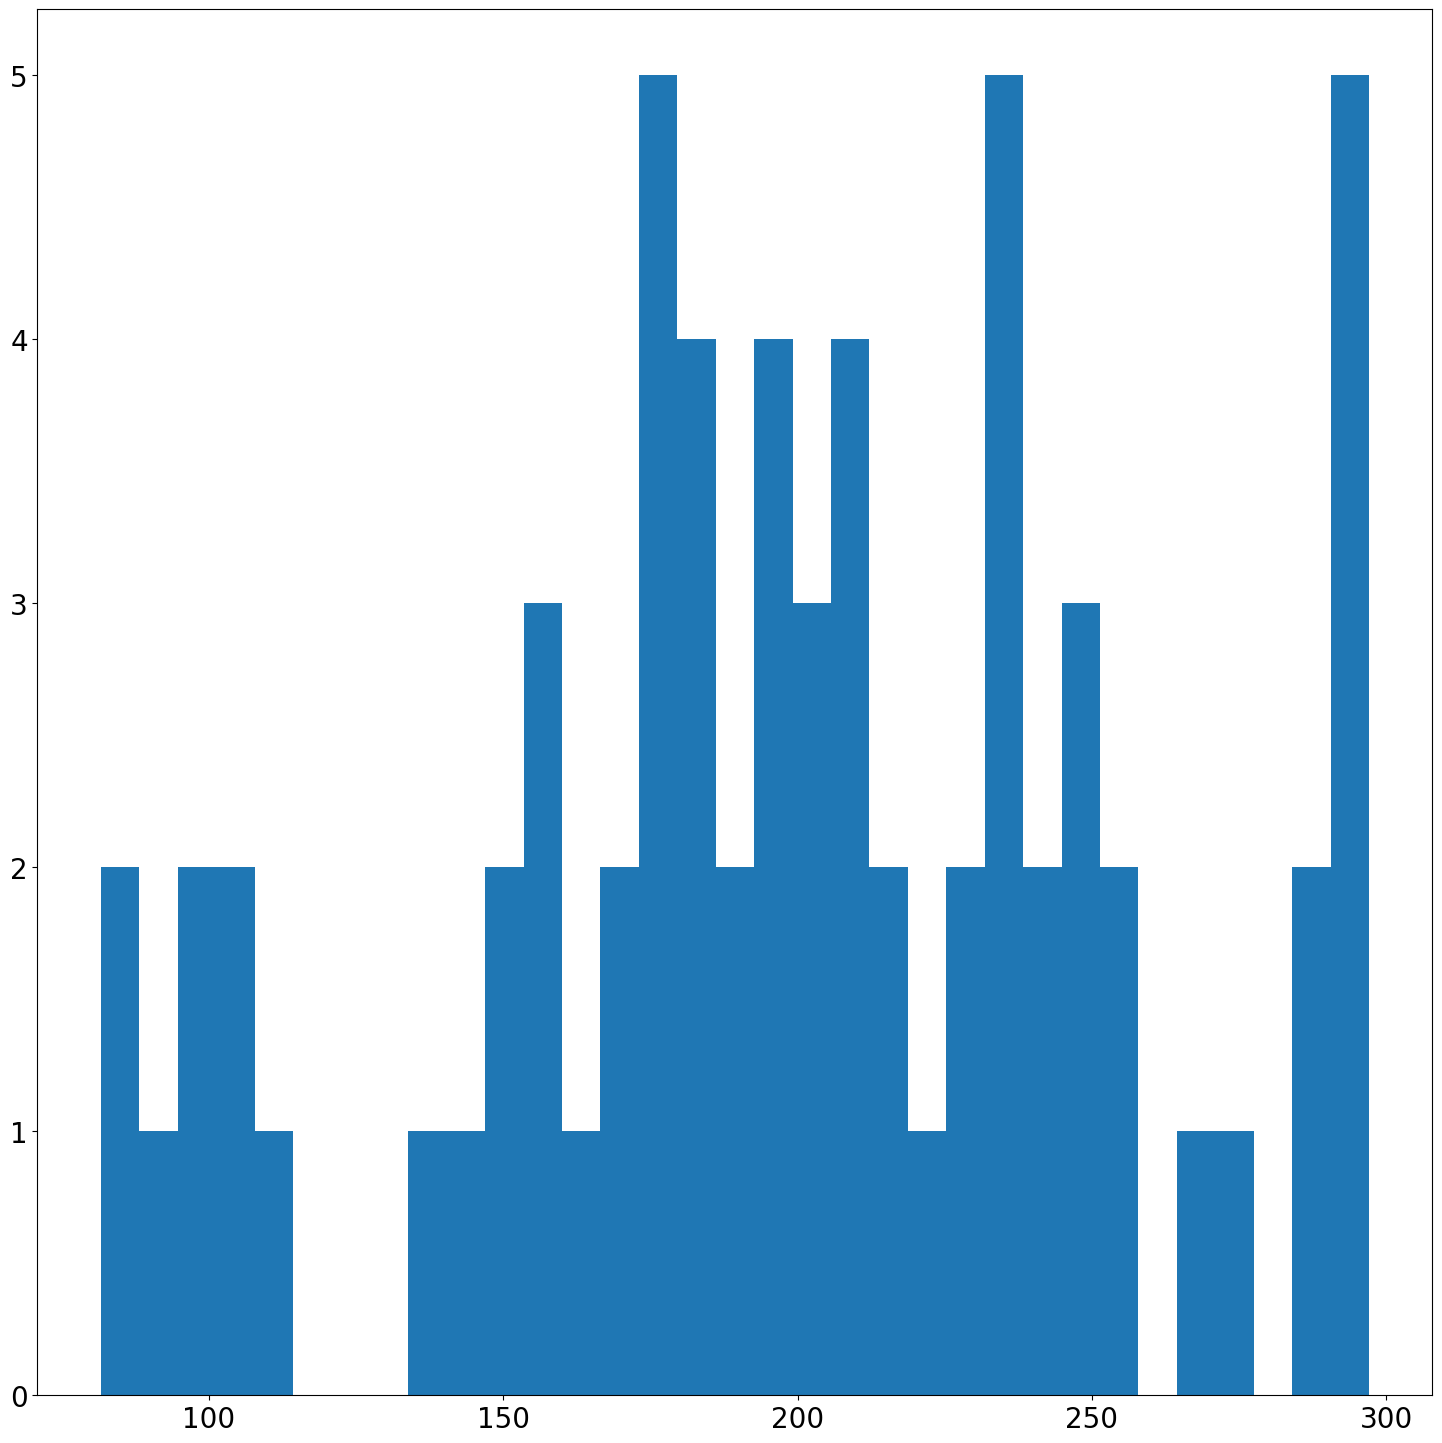

In [9]:
plt.hist(moult_progression_stats, bins = len(moult_progression_stats)//2)
plt.show()